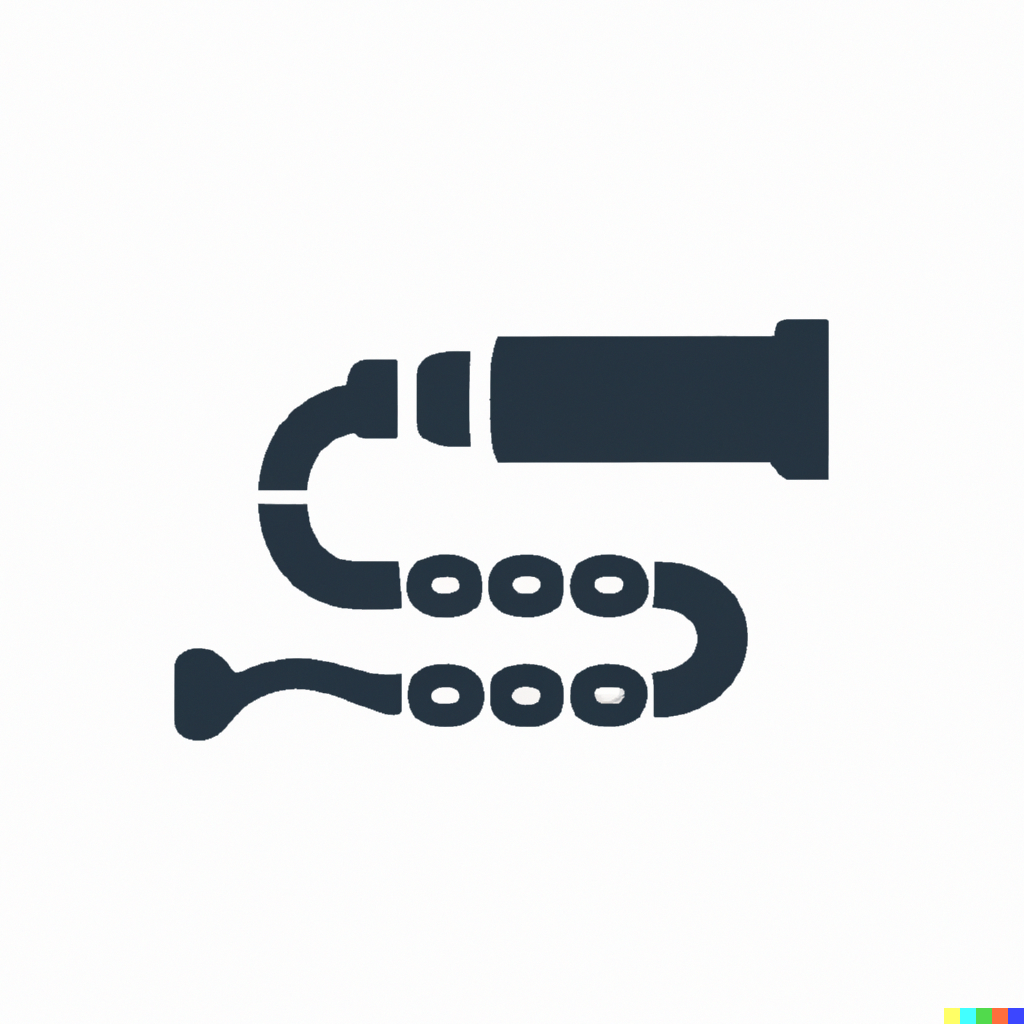

# PyPeriScope
Visual Automation System for Jupyter Lab

## Overview

This Visual Automation System, a digital doppelgänger of human action, operates within the confines of Jupyter Lab. It creates and executes automated workflows based on the recognition of screen elements, much like an artificial eye scanning a landscape.

## Simple Software Dogmas
1. **Keep it simple:** "Strive for simplicity, transparency, and collaboration in your code: Write clear, easily understandable solutions that motivate others to read and contribute. Avoid unnecessary complexity and hidden functionality, as they hinder reliability and knowledge sharing. If you see an opportunity to simplify, speak up and help improve the codebase for everyone."
   
2. **100-Line Rule:** Prioritize user experience with straightforward interfaces and manual fallbacks. Keep code modular and concise, adhering to a 100-line limit for functions, classes, and modules. Favor native implementations over complex libraries when possible, especially with the advent of LLMs. Develop iteratively, starting with failing tests, implementing simple solutions, and optimizing thoughtfully while maintaining clarity.

3. **Communicate with Memes:** "Prioritize clear communication and global accessibility in your work: Create self-documenting code with concise, embedded documentation, leveraging LLM tools for automation. Share your creations widely, focusing on simplicity and ease of adoption over complex functionality. Utilize diverse communication methods, including memes and visual content, to convey ideas effectively across cultural and linguistic barriers. Design with inclusivity in mind, ensuring your tools and solutions are accessible and inviting to a global audience of various skill levels."

Scope Class and Usage Guide
=======================

The `Scope` class is designed for capturing and processing screenshots using Python's `pyautogui` and image manipulation libraries. It allows users to capture a portion of their screen, define specific areas of interest, and save or load these areas as base64-encoded images. Below is an overview of how to use the class.

Initialization
--------------

To initialize the `Scope` class:

```python
scope = Scope(mouse_offset=(100, 100), crop_size=(640, 480), area_offset=(50, 50), area_size=(64, 64))
```

### Parameters:

*   `mouse_offset`: Tuple of x, y coordinates for the mouse position offset.
*   `crop_size`: The dimensions of the captured cropped area.
*   `area_offset`: The offset for the smaller focus area relative to the cursor.
*   `area_size`: The size of the area of interest for finer control.
*   `cursor_size`: Size of the cursor for alignment.

Saving the Data
---------------

You can save the captured images and metadata in a dictionary using `save_dict()`:

```python
data = scope.save_dict()
```

This returns a dictionary containing base64-encoded images and metadata of the screen.

Loading Saved Data
------------------

To reload the saved screenshot and area data, use:

```python
scope.load_from_dict(saved_dict)
```

This restores the screen capture and focus area from previously saved data.

In [259]:
import pyautogui
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import base64
from io import BytesIO

class Scope:
    def __init__(self, saved_dict=None, mouse_offset=(0, 0), area_offset=(0,0),
                 crop_size=(640, 640), area_size=(64, 64), cursor_size=32):
        self.crop_size = tuple(max(size, 640) for size in crop_size)
        self.area_size = tuple(max(size, 32) for size in area_size)
        self.area_offset = area_offset
        self.mouse_offset = tuple(max(offset, 0) for offset in mouse_offset)
        self.cursor_size = cursor_size
        
        if saved_dict:
            self.load_from_dict(saved_dict)
        else:
            self.initial_capture()

    def initial_capture(self):
        self.full_image = pyautogui.screenshot()
        self.full_size = self.full_image.size
        self.update_crop_and_area()

    def update_crop_and_area(self, full_image = None):
        full_screen_image = full_image or self.full_image.copy()
        crop_x = min(max(self.mouse_offset[0] - self.crop_size[0] // 2, 0), self.full_size[0] - self.crop_size[0])
        crop_y = min(max(self.mouse_offset[1] - self.crop_size[1] // 2, 0), self.full_size[1] - self.crop_size[1])
        self.crop_box = (crop_x, crop_y, crop_x + self.crop_size[0], crop_y + self.crop_size[1])

        area_x = self.mouse_offset[0] + self.area_offset[0]
        area_y = self.mouse_offset[1] + self.area_offset[1]
        self.area_box = (area_x, area_y, area_x + self.area_size[0], area_y + self.area_size[1])

        self.cropped_image = full_screen_image.copy().crop(self.crop_box)
        
        area_box_clipped = (
            max(0, self.area_box[0]),
            max(0, self.area_box[1]),
            min(self.full_size[0], self.area_box[2]),
            min(self.full_size[1], self.area_box[3])
        )
        
        self.area_image = full_screen_image.copy().crop(area_box_clipped)

    def encode_image(self, image):
        buffer = BytesIO()
        image.save(buffer, format="PNG")
        return base64.b64encode(buffer.getvalue()).decode('utf-8')

    def save_dict(self):
        output_dict = {
            'area': self.encode_image(self.area_image),
            'clean_preview': self.encode_image(self.cropped_image),
            'image_metadata': {
                'area_box': self.area_box,
                'area_offset': self.area_offset,
                'area_size': self.area_size, 
                'crop_box': self.crop_box, 
                'crop_size': self.crop_size,
                'cursor_size': self.cursor_size,
                'image_size': self.full_size,
                'mouse_offset': self.mouse_offset
            }}
        return output_dict

    def load_from_dict(self, saved_dict):
        self.area_image = np.array(Image.open(BytesIO(base64.b64decode(saved_dict['area']))))
        self.cropped_image = np.array(Image.open(BytesIO(base64.b64decode(saved_dict['clean_preview']))))
        metadata = saved_dict['image_metadata']
        #for attr in ['area_box', 'area_offset', 'area_size', 'crop_box', 'crop_size', 'cursor_size', 'image_size', 'mouse_offset']:
        #    setattr(self, attr, tuple(metadata[attr]))
        self.area_box = metadata['area_box']
        self.area_offset = metadata['area_offset']
        self.area_size = metadata['area_size']
        self.crop_box = metadata['crop_box']
        self.crop_size = metadata['crop_size']
        self.cursor_size = metadata['cursor_size']
        self.full_size = metadata['image_size']
        self.mouse_offset = metadata['mouse_offset']
        # Generate black image in the original desktop size and add only the caprured preview in the right location
        self.full_size = tuple(metadata['image_size'])
        full_image = Image.new('RGB', self.full_size, color='black')
        full_image.paste(Image.fromarray(self.cropped_image), self.crop_box[:2])
        self.full_image = full_image

Scope UI Extension Usage Guide
=================================

This extended `Scope` class builds on the base `Scope` class, introducing methods to render a visual preview of captured areas and mark specific locations on the screen capture. These enhancements allow for annotated and labeled screenshots, highlighting areas of interest.


Rendering a Preview
-------------------

The `render_preview()` method renders the preview of the screen with annotations such as highlighted areas and labels. It can either return the full screen or a cropped version.

### Usage:

```python
preview_image = scope.render_preview(marker={'area': (100, 150, 200, 250), 'mouse_offset': (120, 130), 'label': 'Highlight'})
```

### Parameters:

*   `base_image`: (Optional) Provide a custom image to overlay the preview on, otherwise uses `self.full_image`.
*   `marker`: Dictionary with keys:
    *   `area`: Coordinates of the area to highlight.
    *   `mouse_offset`: Cursor position for crosshair rendering.
    *   `label`: Label text for the highlighted area.
*   `cropped`: If `True`, returns the cropped image, otherwise returns the full image.

In [260]:
class Scope(Scope):
    def render_preview(self, base_image=None, marker=None, cropped=True):
        preview = base_image or self.full_image
        if marker:
            area = marker['area']
            mouse_offset = marker['mouse_offset']
            label_text = marker['label']
        else:
            area = self.area_box
            mouse_offset = self.mouse_offset
            label_text = 'set area:'
        preview = preview.copy()
        area = (area[0], area[2], area[1], area[3])
        draw = ImageDraw.Draw(preview, 'RGBA')
        
        draw.rectangle((area[0],area[2],area[1],area[3]), fill=(255, 165, 0, 128), outline=(255, 0, 0), width=2)
        self.draw_label(draw, (area[0],area[2],area[1],area[3]), label_text, self.cursor_size)
        self.draw_mouse_location(draw, mouse_offset, self.cursor_size)
        if cropped:
            return preview.crop(self.crop_box)       
        else:
            return preview
    
    def draw_mouse_location(self, draw, mouse_offset, cursor_size):
        # Draw the location cross
        draw.line(((mouse_offset[0] - cursor_size // 2, mouse_offset[1]),(mouse_offset[0] + cursor_size // 2, mouse_offset[1])), fill=(0, 255, 255), width=2)
        draw.line(((mouse_offset[0], mouse_offset[1] - cursor_size // 2),(mouse_offset[0], mouse_offset[1] + cursor_size // 2)), fill=(0, 255, 255), width=2)
        
    def draw_label(self, draw, area, label_text, cursor_size):
        try:
            font = ImageFont.truetype("arialbd.ttf", cursor_size // 2 - 2)
        except IOError:
            font = ImageFont.load_default()
        
        label_text = label_text.upper()
        label_bbox = draw.textbbox((0, 0), label_text, font=font)
        
        label_position = (area[0] + 5, area[1] + 1)  # 5 pixels offset from the top-left corner
        label_bg = (label_position[0] - 5, label_position[1], label_position[0] + (label_bbox[2] - label_bbox[0]) + 6, label_position[1] + (label_bbox[3] - label_bbox[1]) + 6)
        draw.rectangle(label_bg, fill=(255, 0, 0))  # Red background
        
        # Draw label text
        draw.text(label_position, label_text, fill=(255, 255, 255), font=font) 

Make the object sharable as plain text
=================================

Scope extension to add DataBoomer output with save_string command
Here is how you use it: You make the step, once done call save_string and go paste the contents of the cell into the workbook of your choosing


In [1]:
from elvis_repl import elvis
from databoomer import DataBoomer
from string import Template

class Scope(Scope):
    def save_string(self):
        new_template = Template("# comment: Automated step generated with pyPeriscope V2 $comment\npayload = \'\'\'$payload\'\'\'\n$obj_name = Scope(saved_dict=dill.loads(codecs.decode(payload.encode(), 'base64')))")
        self.DataBoomer = DataBoomer(self.save_dict(), obj_name = "step", template = new_template)
        e = elvis()
        e.leave(self.DataBoomer.payload)

NameError: name 'Scope' is not defined

Scope Find and Draw Class Extension Usage Guide
===============================================

This extension to the `Scope` class adds functionality for detecting and marking patterns on the screen. It uses `pyautogui` to search for instances of a specific area of interest (`area_image`) within the screen and highlights these occurrences. Additionally, it provides methods to render the found locations on the captured screen.


Pattern Detection
-----------------

The `find()` method identifies all occurrences of the predefined `area_image` on the screen with a confidence threshold. The detected locations are stored and can be visually rendered.

### Usage:

```python
scope.find()
```

### How It Works:

*   Captures the current screen using `pyautogui.screenshot()`.
*   Searches for occurrences of `self.area_image` on the screen using `pyautogui.locateAllOnScreen()` with a 90% confidence level.
*   For each occurrence, it generates metadata for the location (bounding box, mouse offset, and label).
*   Ensures non-overlapping areas by checking with the `overlap()` method.
*   The number of detected patterns is printed at the end.

Drawing Detected Patterns
-------------------------

Once patterns are detected, the `draw_found()` method renders all found locations onto the screenshot. Each occurrence is labeled and marked on the screen, allowing users to visually identify the detected areas.

### Usage:

```python
found_image = scope.draw_found(found_id=0)
found_image.show()
```

### Parameters:

*   `found_id`: Index of the found location to render. Defaults to `0`, which is the first found location.

### How It Works:

*   The base screenshot is used to overlay detected patterns.
*   The method calls `render_preview()` to draw the label and highlight each found location.
*   The final image can be cropped to the original area defined by `self.crop_box`.


    

Output and Display
------------------

The `draw_found()` method generates an annotated screenshot with all found patterns highlighted. You can crop the image or display it using Pillow's `Image.show()` method, or save it for further analysis.

This extension is especially useful in automating the process of detecting patterns on the screen and providing clear visual feedback on the results.

In [264]:
class Scope(Scope):
    def find(self):
        count = 1
        self.found_locations = []
        self.found_image = pyautogui.screenshot()
        found_patterns = pyautogui.locateAllOnScreen(self.area_image, confidence=0.9)

        for loc in found_patterns:
            new_loc = {'area':(loc.left, loc.top, loc.left + self.area_size[0], loc.top + self.area_size[1]),
                                         'mouse_offset':(loc.left - self.area_offset[0], loc.top - self.area_offset[1]), 
                                         'label':"[0] STEP", 
                                         'area_offset':self.area_offset}

            if self.found_locations == []: 
                self.found_locations.append(new_loc)
                continue

            if not(self.overlap(self.found_locations[-1], new_loc)):
                new_loc['label'] = "["+str(count)+"] STEP"
                self.found_locations.append(new_loc)
                count = count + 1
                continue

        print("found: " + str(count))

    def overlap(self, area1, area2):
        x1, y1, x2, y2 = area1['area']
        x3, y3, x4, y4 = area2['area']
        
        if x3 < x2: # check X overlap
            return True
        if y3 < y2: # check Y overlap
            return True
        return False
        
    def draw_found(self, found_id=0):
        base_image = self.found_image.copy()
        self.mouse_offset = self.found_locations[found_id]['mouse_offset']
        self.area_offset = self.found_locations[found_id]['area_offset']
        self.update_crop_and_area(full_image=base_image)
        
        for loc in self.found_locations:
            base_image = self.render_preview(base_image, marker=loc, cropped=False)

        return base_image.crop(self.crop_box) 

# Scope String Generator

A utility method for the `Scope` class that helps generate new scope configurations from existing ones. This is particularly useful when:
- A recorded step doesn't work and you need to create a new step from the current position
- You want to create a new empty step while preserving parameters from an existing step

## Usage

### Basic Usage

```python
# Get string representation of current scope
current_step = Scope(mouse_offset=(10, 20))
print(current_step.generate_scope_string())
# Output: step = Scope(mouse_offset=(10, 20))
```

### Creating New Step from Current Position

If your recorded step isn't working, you can create a new one from your current position:

```python
# Create new step from current position
new_step = Scope()  # Empty step
current_step = Scope(area_size=(128, 128))  # Current position
print(new_step.generate_scope_string(current_step))
# Output: step = Scope(area_size=(128, 128))
```

### Parameters

The method takes one optional parameter:
- `step` (Scope, optional): Another Scope object to use as reference. If not provided, uses the current instance.

### Default Values

The method compares against these default values:
- `mouse_offset`: (0, 0)
- `area_offset`: (0, 0)
- `area_size`: (64, 64)
- `crop_size`: (640, 640)
- `cursor_size`: 32

Only non-default values will be included in the output string.

## Examples

```python
# Using current scope
step1 = Scope(mouse_offset=(10, 20), area_size=(128, 128))
print(step1.generate_scope_string())
# Output: step = Scope(mouse_offset=(10, 20), area_size=(128, 128))

# Using another scope as reference
step2 = Scope()  # Empty step
print(step2.generate_scope_string(step1))
# Output: step = Scope(mouse_offset=(10, 20), area_size=(128, 128))

# Using default values
step3 = Scope()
print(step3.generate_scope_string())
# Output: step = Scope()
```

In [265]:
class Scope(Scope):
    def generate_scope_string(self, step=None):
        
        if step==None:
            step=self
        
        defaults = {'mouse_offset': (0, 0), 'area_offset': (0, 0), 'area_size': (64, 64), 'crop_size': (640, 640), 'cursor_size': 32}
        current_values = {'mouse_offset': step.mouse_offset, 'area_offset': step.area_offset, 'area_size': step.area_size, 'crop_size': step.crop_size, 'cursor_size': step.cursor_size}
        
        # Filter out values that match defaults
        non_default = {
            key: value for key, value in current_values.items()
            if value != defaults[key]
        }
        
        if not non_default:
            return "step = Scope()"
        
        # Format non-default values
        params = []
        for key, value in non_default.items():
            if isinstance(value, tuple):
                formatted_value = str(value)
            else:
                formatted_value = str(value)
            params.append(f"{key}={formatted_value}")
        
        return f"step = Scope({', '.join(params)})"

create scope rec(how many click to start, how many clicks to rec)
- [ ] Rec step
- [ ] Rec many
- [ ] Ignore 1st

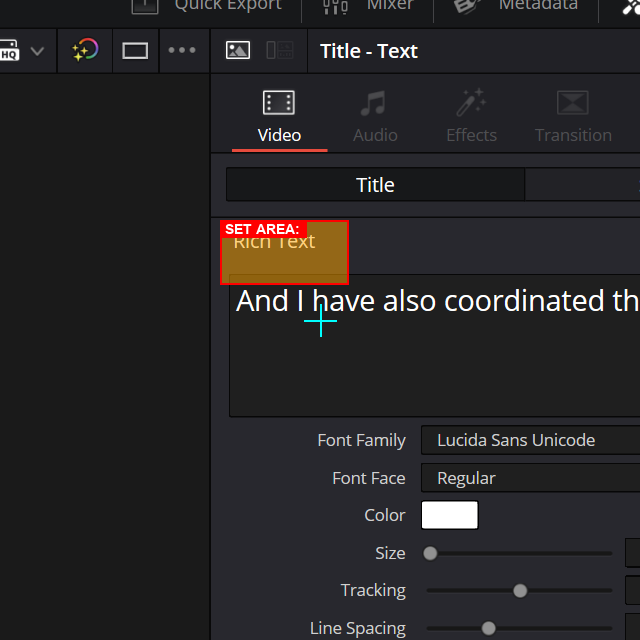

In [278]:
test = Scope(mouse_offset=(2650,420), area_offset=(-100,-100), area_size=(128,64))
#test.find()
#test.draw_found()
test.render_preview()
#test.area_offset

In [279]:
test.find()

found: 1
